In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from imblearn.over_sampling import SMOTENC
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score

from sklearn.preprocessing import OneHotEncoder

from sklearn.compose import make_column_transformer
from sklearn.pipeline import Pipeline

from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression

from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

pd.set_option('display.max_columns', 100)
pd.options.display.float_format = '{:.4f}'.format

import warnings
warnings.filterwarnings("ignore")

In [27]:
data = pd.read_csv('/home/maksonvinicio/Documents/GitHub/Data-Science-Projects/Maratona Behind the Code 2021/05_Sonda/Data/dataset.csv')
answers = pd.read_csv('/home/maksonvinicio/Documents/GitHub/Data-Science-Projects/Maratona Behind the Code 2021/05_Sonda/Data/ANSWERS.csv')

In [5]:
data.head()

,ID,GENDER,SENIORCITIZEN,PARTNER,DEPENDENTS,TENURE,PHONESERVICE,MULTIPLELINES,INTERNETSERVICE,ONLINESECURITY,ONLINEBACKUP,DEVICEPROTECTION,TECHSUPPORT,STREAMINGTV,STREAMINGMOVIES,CONTRACT,PAPERLESSBILLING,PAYMENTMETHOD,MONTHLYCHARGES,TOTALCHARGES,CHURN
0,3418,Female,0.0000,No,No,26.0000,Yes,No,DSL,No,Yes,Yes,No,No,No,Month-to-month,Yes,Credit card (automatic),131.5500,1483.7,No
1,6865,Male,0.0000,No,No,39.0000,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Credit card (automatic),79.6100,2737.31,No
2,2799,Male,0.0000,No,No,1.0000,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Credit card (automatic),9.2600,9.26,No
3,1584,Male,0.0000,Yes,Yes,66.0000,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,Yes,Credit card (automatic),42.1400,1689.19,No
4,9997,Male,0.0000,No,No,56.0000,Yes,Yes,Fiber optic,No,Yes,No,No,Yes,Yes,Month-to-month,No,Electronic check,126.2400,5608.69,No


In [28]:
data = data.dropna(axis=0)
data['TOTALCHARGES'] = data['TOTALCHARGES'].apply(lambda x: x.replace(' ', '9999999999'))
data['TOTALCHARGES'] = data['TOTALCHARGES'].astype(float)
data['TOTALCHARGES'] = data['TOTALCHARGES'].apply(lambda x: data['TOTALCHARGES'].median() if x == 9999999999 else x)

data['CHURN'] = data['CHURN'].apply(lambda x: 1 if x == 'Yes' else 0)

In [29]:
answers['TOTALCHARGES'] = answers['TOTALCHARGES'].apply(lambda x: x.replace(' ', '9999999999'))
answers['TOTALCHARGES'] = answers['TOTALCHARGES'].astype(float)
answers['TOTALCHARGES'] = answers['TOTALCHARGES'].apply(lambda x: answers['TOTALCHARGES'].median() if x == 9999999999 else x)

In [22]:
data.head(2)

,ID,GENDER,SENIORCITIZEN,PARTNER,DEPENDENTS,TENURE,PHONESERVICE,MULTIPLELINES,INTERNETSERVICE,ONLINESECURITY,ONLINEBACKUP,DEVICEPROTECTION,TECHSUPPORT,STREAMINGTV,STREAMINGMOVIES,CONTRACT,PAPERLESSBILLING,PAYMENTMETHOD,MONTHLYCHARGES,TOTALCHARGES,CHURN
0,3418,Female,0.0000,No,No,26.0000,Yes,No,DSL,No,Yes,Yes,No,No,No,Month-to-month,Yes,Credit card (automatic),131.5500,1483.7000,0
1,6865,Male,0.0000,No,No,39.0000,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Credit card (automatic),79.6100,2737.3100,0


# Split data

In [30]:
X = data.drop(['ID', 'CHURN'], axis=1)
y = data['CHURN']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=42)

<AxesSubplot:>

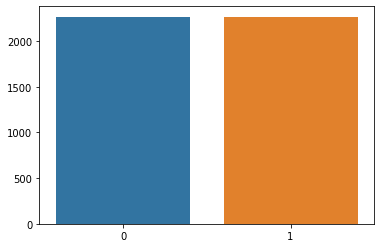

In [31]:
categorical_columns = [0, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
smote = SMOTENC(random_state=42, categorical_features=categorical_columns)

X_over, y_over = smote.fit_sample(X_train, y_train)

sns.barplot(y_over.value_counts().index, y_over.value_counts().values)

In [32]:
def encoder_ohe(cols_ohe, ohe, X_train, X_val):
    for col in cols_ohe:
        colunas_ohe = ohe.fit_transform(X_train[[col]])
        colunas_ohe_teste = ohe.transform(X_val[[col]])
        
        categorias_ohe = ohe.categories_[0]
        
        for indice, nome_categoria in enumerate(categorias_ohe):
            X_train[nome_categoria] = colunas_ohe[:, indice]
            X_val[nome_categoria] = colunas_ohe_teste[:, indice]
        X_train = X_train.drop(col, axis=1)
        X_val = X_val.drop(col, axis=1)

    return X_train, X_val

In [10]:
# encoder_columns = X_train.columns[categorical_columns]
# ohe = OneHotEncoder(sparse=False)
# X_over, X_val = encoder_ohe(encoder_columns, ohe, X_over, X_val)

# 0.0 - Pipeline

In [33]:
encoder_columns = X_over.columns[categorical_columns]

column_transformer = make_column_transformer(
    (OneHotEncoder(), categorical_columns),
    remainder='passthrough')

pipe = Pipeline([
    ('transformer', column_transformer),
    ('model',  LGBMClassifier(n_estimators=1000, learning_rate=0.009, num_leaves=7, n_jobs=-1, max_depth=13, random_state=42))
])

In [34]:
pipe.fit(X_over, y_over)

pipe.score(X_val, y_val)

0.7867575462512172

In [35]:
from sklearn.metrics import f1_score

y_pred = pipe.predict(X_val)

f1_score(y_val, y_pred, average='weighted')

0.7904354352075884

In [36]:
pred_sub = pipe.predict(answers.drop(['ID', 'CHURN'], axis=1))

In [40]:
answers['CHURN'] = pred_sub

In [44]:
answers['CHURN'] = answers['CHURN'].apply(lambda x: 'Yes' if x == 1 else 'No')

In [47]:
# answers.to_csv('/home/maksonvinicio/Documents/GitHub/Data-Science-Projects/Maratona Behind the Code 2021/05_Sonda/Data/submission.csv', index=False)

# 1.0 - LGBM

In [ ]:
model = LGBMClassifier(n_estimators=1000, learning_rate=0.01, num_leaves=7, n_jobs=-1)
model.fit(X_over, y_over)

y_pred = model.predict(X_val)

model.score(X_val, y_val)

In [13]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

cross_val_score(model, X_over, y_over, cv=cv).mean()

0.8280973451327434

In [ ]:
pipe.fit(X_over, y_over)

pipe.score(X_val, y_val)

0.7865497076023392

In [15]:
from sklearn.metrics import f1_score

f1_score(y_val, y_pred, average='weighted')

0.8045552317876613

              precision    recall  f1-score   support

           0       0.89      0.84      0.86       766
           1       0.59      0.68      0.63       260

    accuracy                           0.80      1026
   macro avg       0.74      0.76      0.75      1026
weighted avg       0.81      0.80      0.80      1026



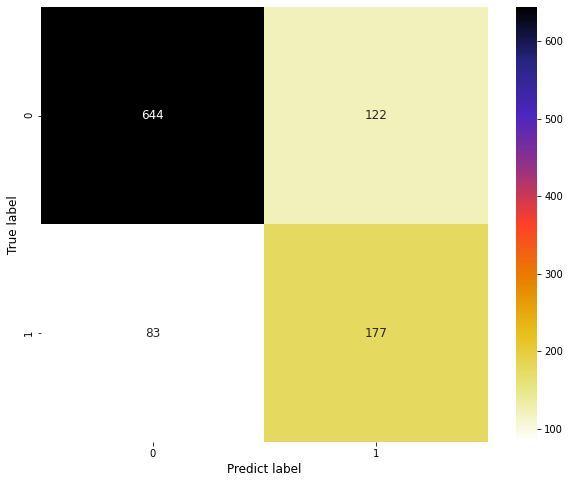

In [14]:
print(classification_report(y_val, y_pred))

cm = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, cmap='CMRmap_r', fmt='.0f', annot_kws={'size': 12})
plt.xlabel('Predict label', fontsize=12)
plt.ylabel('True label', fontsize=12)
plt.show()

# 2.0 - Logistic Regression

In [118]:
logreg = LogisticRegression().fit(X_over, y_over)

y_pred_reg = model.predict(X_val)

logreg.score(X_val, y_val)

0.7807017543859649

In [138]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

cross_val_score(logreg, X_over, y_over, cv=cv).mean()

0.7953539823008849

              precision    recall  f1-score   support

           0       0.89      0.83      0.86       766
           1       0.58      0.69      0.63       260

    accuracy                           0.80      1026
   macro avg       0.73      0.76      0.74      1026
weighted avg       0.81      0.80      0.80      1026



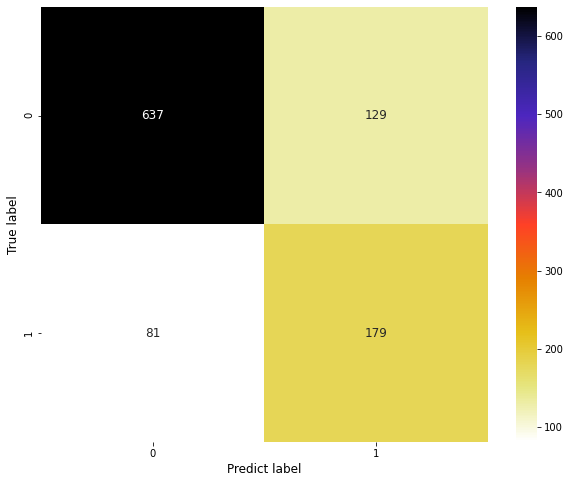

In [103]:
print(classification_report(y_val, y_pred_reg))

cm = confusion_matrix(y_val, y_pred_reg)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, cmap='CMRmap_r', fmt='.0f', annot_kws={'size': 12})
plt.xlabel('Predict label', fontsize=12)
plt.ylabel('True label', fontsize=12)
plt.show()

# 3.0 - Ensemble

In [129]:
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import RandomForestClassifier

In [139]:
estimators = [
    ('logreg', LogisticRegression()),
    ('lgbm', LGBMClassifier(n_estimators=1000, learning_rate=0.01, num_leaves=7, n_jobs=-1)),
    ('rf', RandomForestClassifier(n_estimators=1000, n_jobs=-1, min_samples_leaf=7, criterion='gini')),
]

clf = StackingClassifier(estimators, final_estimator=LGBMClassifier())

clf.fit(X_over, y_over)

clf.score(X_val, y_val)

0.7904483430799221

In [140]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

cross_val_score(clf, X_over, y_over, cv=cv).mean()

0.8232300884955752

# Feature Selection

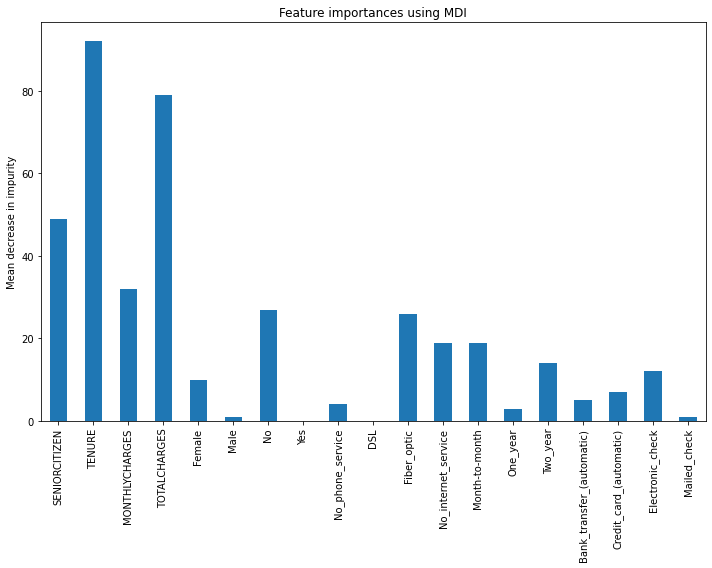

In [63]:
feature_names = model.feature_name_
importances = model.feature_importances_

forest_importances = pd.Series(importances, index=feature_names) 

fig, ax = plt.subplots(figsize=(10, 8))
forest_importances.plot.bar(ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [64]:
from sklearn.metrics import log_loss

In [66]:
p = model.predict_proba(X_val)
loss = log_loss(y_val, p)
loss

0.4298939325408906

In [68]:
from sklearn.metrics import classification_report, confusion_matrix, log_loss
res = {}

for col in X_val.columns:
    Xval = X_val.copy()
    Xval[col] = np.random.permutation(Xval[col])

    p = model.predict_proba(Xval)

    ll = log_loss(y_val, p)
    res[col] = ll

    print(f'Feature: {col}  -  LL Delta: {(loss - ll) * -1 :.4f}')

Feature: SENIORCITIZEN  -  LL Delta: 0.0013
Feature: TENURE  -  LL Delta: 0.0592
Feature: MONTHLYCHARGES  -  LL Delta: -0.0019
Feature: TOTALCHARGES  -  LL Delta: 0.0084
Feature: Female  -  LL Delta: 0.0014
Feature: Male  -  LL Delta: 0.0002
Feature: No  -  LL Delta: -0.0009
Feature: Yes  -  LL Delta: -0.0000
Feature: No phone service  -  LL Delta: 0.0002
Feature: DSL  -  LL Delta: -0.0000
Feature: Fiber optic  -  LL Delta: 0.0325
Feature: No internet service  -  LL Delta: -0.0057
Feature: Month-to-month  -  LL Delta: 0.0430
Feature: One year  -  LL Delta: -0.0002
Feature: Two year  -  LL Delta: 0.0104
Feature: Bank transfer (automatic)  -  LL Delta: -0.0000
Feature: Credit card (automatic)  -  LL Delta: -0.0004
Feature: Electronic check  -  LL Delta: 0.0003
Feature: Mailed check  -  LL Delta: 0.0000


In [69]:
print((loss - pd.Series(res)).sort_values() * -1)

TENURE                       0.06
Month-to-month               0.04
Fiber optic                  0.03
Two year                     0.01
TOTALCHARGES                 0.01
Female                       0.00
SENIORCITIZEN                0.00
Electronic check             0.00
No phone service             0.00
Male                         0.00
Mailed check                 0.00
Yes                         -0.00
DSL                         -0.00
Bank transfer (automatic)   -0.00
One year                    -0.00
Credit card (automatic)     -0.00
No                          -0.00
MONTHLYCHARGES              -0.00
No internet service         -0.01
dtype: float64


# Deep learning

In [93]:
def FeedForward():
    model = Sequential()
    model.add(Dense(units=6, activation='relu', input_dim=19))
    model.add(Dense(units = 6, activation = 'relu'))
    model.add(Dense(units = 6, activation = 'relu'))
    model.add(Dense(units = 6, activation = 'relu'))
    model.add(Dense(units = 1, activation = 'sigmoid'))

    model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

    return model

In [94]:
history = KerasClassifier(FeedForward, epochs=100, batch_size=10, verbose=0)

history.fit(X_over, y_over)

In [96]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

cross_val_score(history, X_over, y_over, cv=cv)

array([0.80199116, 0.79646015, 0.77323008, 0.81194693, 0.77433628])

In [86]:
pred = model.predict(X_val)
pred = (pred > 0.5)

Relatório de Classificação:
               precision    recall  f1-score   support

           0     0.8547    0.8982    0.8759       766
           1     0.6471    0.5500    0.5946       260

    accuracy                         0.8099      1026
   macro avg     0.7509    0.7241    0.7352      1026
weighted avg     0.8021    0.8099    0.8046      1026



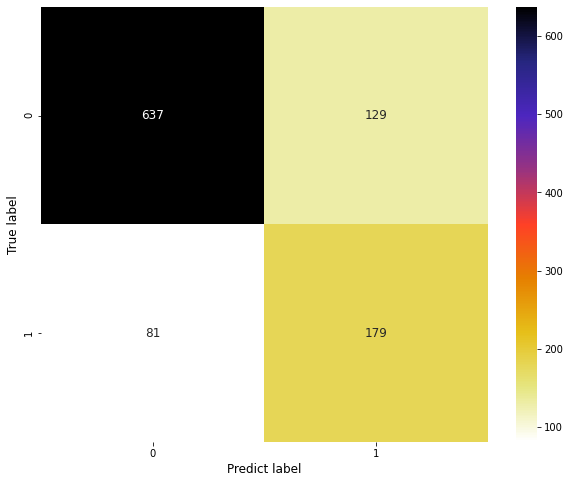

In [87]:
print("Relatório de Classificação:\n", classification_report(y_val, pred, digits=4))
cm = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, cmap='CMRmap_r', fmt='.0f', annot_kws={'size': 12})
plt.xlabel('Predict label', fontsize=12)
plt.ylabel('True label', fontsize=12)
plt.show()